# 北京二手房房价分析与预测

作者：xiaoyu

时间：2018.4.11

### 项目简介
本项目根据个人需求进行北京二手房信息的数据分析，通过数据分析观察住房特征规律，利用机器学习模型进行简单的预测。
### 数据源
通过爬虫爬取第三方房屋中间商网站（链家和安居客）获取数据源，仅供学习使用。
>注：爬虫源代码见`spiders`文件夹。

### 目的
北京房价是最受关注的话题。因此，本项目以研究北京二手房房价为目的，对二手房房价进行数据分析，并希望能对未来房价进行预测（仅供参考）。
- 统计北京各区域二手房房价情况
- 统计北京各区域二手房数量
- 统计西城区、东城区和海淀区各地方二手房房价
- 统计房价与房屋面积区段的房屋数量
- 预测北京二手房房价

### 技术和工具
本项目以Python语言编程完成从爬取，数据分析，到预测。

- 爬虫工具：`scrapy` ，`beautifulsoup`
- 数据分析：`pandas`，`numpy`，`matplolib`
- 机器学习：`sklearn`


## 1. 初探数据

### 导入库包

In [228]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl

import matplotlib.pyplot as plt
from IPython.display import display
plt.style.use("fivethirtyeight")
sns.set_style({'font.sans-serif':['simhei','Arial']})
%matplotlib inline


# 检查Python版本
from sys import version_info
if version_info.major != 3:
    raise Exception('请使用Python 3 来完成此项目')

### 导入数据

In [229]:
# 导入链家二手房数据
lianjia_df = pd.read_csv('lianjia.csv')
display(lianjia_df.head(n=2))

# 检查缺失值情况
lianjia_df.info()

,Direction,District,Elevator,Floor,Garden,Id,Layout,Price,Region,Renovation,Size,Year
0,东西,灯市口,NaN,6,锡拉胡同21号院,101102647043,3室1厅,780.0,东城,精装,75.0,1988
1,南北,东单,无电梯,6,东华门大街,101102650978,2室1厅,705.0,东城,精装,60.0,1988


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23677 entries, 0 to 23676
Data columns (total 12 columns):
Direction     23677 non-null object
District      23677 non-null object
Elevator      15440 non-null object
Floor         23677 non-null int64
Garden        23677 non-null object
Id            23677 non-null int64
Layout        23677 non-null object
Price         23677 non-null float64
Region        23677 non-null object
Renovation    23677 non-null object
Size          23677 non-null float64
Year          23677 non-null int64
dtypes: float64(2), int64(3), object(7)
memory usage: 2.2+ MB


In [230]:
lianjia_df.describe()

,Floor,Id,Price,Size,Year
count,23677.000000,2.367700e+04,23677.000000,23677.000000,23677.000000
mean,12.765088,1.011024e+11,610.668319,99.149301,2001.326519
std,7.643932,5.652477e+05,411.452107,50.988838,9.001996
min,1.000000,1.010886e+11,60.000000,2.000000,1950.000000
25%,6.000000,1.011022e+11,365.000000,66.000000,1997.000000
50%,11.000000,1.011025e+11,499.000000,88.000000,2003.000000
75%,18.000000,1.011027e+11,717.000000,118.000000,2007.000000
max,57.000000,1.011028e+11,6000.000000,1019.000000,2017.000000


- 除了预测目标 **Price**，一共有11个特征；
- 用 **info()** 查询了缺失值，只有 **Elevator** 一项存在缺失值，这个放在后面进行处理；

In [231]:
# 添加新特征房屋均价
df = lianjia_df.copy()
df['PerPrice'] = lianjia_df['Price']/lianjia_df['Size']

# 重新摆放列位置
columns = ['Region', 'District', 'Garden', 'Layout', 'Floor', 'Year', 'Size', 'Elevator', 'Direction', 'Renovation', 'PerPrice', 'Price']
df = pd.DataFrame(df, columns = columns)

# 重新审视数据集
display(df.head(n=2))

,Region,District,Garden,Layout,Floor,Year,Size,Elevator,Direction,Renovation,PerPrice,Price
0,东城,灯市口,锡拉胡同21号院,3室1厅,6,1988,75.0,NaN,东西,精装,10.40,780.0
1,东城,东单,东华门大街,2室1厅,6,1988,60.0,无电梯,南北,精装,11.75,705.0


- 由于 **Id** 特征并无实际意义，只是每套二手房的编号，故去掉；
- 重新排列后的特征共有 **10** 个；

## 3.机器学习预测北京二手房房价

机器学习需要输入好的数据集，有意义的特征字段才能使得结果更加准确。

北京二手房房价预测项目中的数据集的特征有：
- **Size：**房屋面积，平方米
- **Layout：**房间数，间
- **Year: **房屋建造时间，年
- **Floor: **房屋所处楼层，层
- **Elevator: ** 是否有电梯
- **Renovation: ** 是否是精装修，或者简装
- **Region：**北京的区域
目标变量：
- **Price: **房屋人民币售价，万

策略方法：
- 使用**决策树**的回归模型对二手房房价进行分析预测
- 使用**交叉验证**方法充分利用数据集进行训练，避免数据划分不均匀的影响。
- 使用**GridSearchCV**方法优化模型参数
- 使用**R2**评分方法对预测打分

### 数据预处理

可以看到，数据集中的数据类型有文本，类目，数值等。由于需要将数据集作为输入给机器学习模型计算，而数据类型统一为数值型才能计算，因此将数据类型全部转换为数值类型，以很好的为机器学习模型服务。

### 数据清洗

In [232]:
df.head(10)

,Region,District,Garden,Layout,Floor,Year,Size,Elevator,Direction,Renovation,PerPrice,Price
0,东城,灯市口,锡拉胡同21号院,3室1厅,6,1988,75.0,NaN,东西,精装,10.400000,780.0
1,东城,东单,东华门大街,2室1厅,6,1988,60.0,无电梯,南北,精装,11.750000,705.0
2,东城,崇文门,新世界中心,3室1厅,16,1996,210.0,有电梯,南西,其他,6.666667,1400.0
3,东城,崇文门,兴隆都市馨园,1室1厅,7,2004,39.0,NaN,南,精装,10.769231,420.0
4,东城,陶然亭,中海紫御公馆,2室2厅,19,2010,90.0,有电梯,南,精装,11.088889,998.0
5,东城,广渠门,幸福家园二期,2室1厅,18,2003,111.0,有电梯,南北,其他,10.630631,1180.0
6,东城,西罗园,西革新里110号院,1室1厅,6,1992,42.0,无电梯,南,其他,7.595238,319.0
7,东城,西罗园,建予园,2室1厅,16,1999,105.0,有电梯,南,其他,6.095238,640.0
8,东城,东花市,富贵园一区,3室2厅,9,2003,161.0,有电梯,南北,精装,11.055901,1780.0
9,东城,东直门,万国城MOMA,2室2厅,25,2002,127.0,有电梯,东北,精装,10.236220,1300.0


In [233]:
df.loc[df['Direction']=='东南西南']

,Region,District,Garden,Layout,Floor,Year,Size,Elevator,Direction,Renovation,PerPrice,Price
688,门头沟,滨河西区,承泽苑,2室1厅,6,2000,72.0,无电梯,东南西南,简装,3.888889,280.0
11575,丰台,方庄,芳城园一区,2室1厅,27,1994,65.0,有电梯,东南西南,精装,6.615385,430.0
12745,丰台,科技园区,恒富花园2号院,3室1厅,21,1999,135.0,有电梯,东南西南,其他,4.703704,635.0
13148,丰台,科技园区,怡海花园富润园,4室3厅,29,2002,294.0,有电梯,东南西南,精装,5.442177,1600.0
13378,丰台,玉泉营,鸿业兴园一区,2室1厅,21,2006,89.0,有电梯,东南西南,简装,5.842697,520.0
14802,海淀,世纪城,远大园五区,2室1厅,16,2001,126.0,有电梯,东南西南,其他,9.515873,1199.0
17707,朝阳,亚运村,慧忠北里,3室2厅,24,2000,205.0,有电梯,东南西南,简装,5.365854,1100.0
17719,朝阳,亚运村,慧忠北里,3室2厅,24,2000,205.0,有电梯,东南西南,简装,5.365854,1100.0
17752,朝阳,望京,望京新城,2室2厅,30,1998,115.0,有电梯,东南西南,精装,6.521739,750.0
18288,朝阳,望京,望京新城,2室1厅,26,1998,105.0,NaN,东南西南,精装,7.142857,750.0


In [234]:
df['Layout'].value_counts()

2室1厅      9485
3室1厅      3999
3室2厅      2765
1室1厅      2681
2室2厅      1671
4室2厅       930
1室0厅       499
4室1厅       295
5室2厅       200
2房间1卫      170
1房间1卫      146
3房间1卫      116
4室3厅        96
5室3厅        75
1室2厅        67
6室2厅        59
3房间2卫       53
2室0厅        50
3室3厅        43
4房间2卫       31
3室0厅        29
6室3厅        29
5室1厅        27
叠拼别墅        20
2房间2卫       18
4房间1卫       15
1房间0卫       15
5房间2卫       10
7室3厅         7
4房间3卫        7
7室2厅         6
5房间3卫        6
2室3厅         5
6室4厅         4
5室4厅         4
8室3厅         4
4室4厅         4
8室2厅         3
6房间4卫        3
3房间0卫        3
4室0厅         3
3房间3卫        2
2房间0卫        2
1房间2卫        2
6房间3卫        2
6室0厅         2
6房间5卫        1
11房间3卫       1
9室1厅         1
9室2厅         1
8室4厅         1
5房间0卫        1
6室5厅         1
6室1厅         1
9室3厅         1
7室1厅         1
8室5厅         1
7房间2卫        1
1室3厅         1
5室0厅         1
Name: Layout, dtype: int64

In [235]:
df['Direction'].value_counts()

南北          11391
南            2845
东西           1403
东南           1346
西南           1122
东             934
西             889
西北            765
东北            677
北             610
东南北           467
南西北           371
南西            164
东西北           141
东南西           134
西南北           124
东南西北           90
西南东北           24
南东北            19
东南西南           15
东南南            14
西南西北           10
西东北            10
东东南            10
南西南             9
东西南             9
东南东北            8
西南西             6
东南南北            5
南西东北            3
            ...  
260.07平米        1
东南西北北           1
北西              1
335.51平米        1
东南南西北           1
东西东北            1
294.42平米        1
259.76平米        1
东西北东北           1
东南西南北           1
264.6平米         1
南北西             1
北南              1
西南西北东北          1
南北东             1
东南北西            1
南北东北            1
东西北北            1
242.78平米        1
259.87平米        1
240.97平米        1
东南西北东北          1
292.31平米        1
361.8平米         1
东东南南      

In [236]:
df.head()

,Region,District,Garden,Layout,Floor,Year,Size,Elevator,Direction,Renovation,PerPrice,Price
0,东城,灯市口,锡拉胡同21号院,3室1厅,6,1988,75.0,NaN,东西,精装,10.400000,780.0
1,东城,东单,东华门大街,2室1厅,6,1988,60.0,无电梯,南北,精装,11.750000,705.0
2,东城,崇文门,新世界中心,3室1厅,16,1996,210.0,有电梯,南西,其他,6.666667,1400.0
3,东城,崇文门,兴隆都市馨园,1室1厅,7,2004,39.0,NaN,南,精装,10.769231,420.0
4,东城,陶然亭,中海紫御公馆,2室2厅,19,2010,90.0,有电梯,南,精装,11.088889,998.0


In [237]:
df['Region'].dtype

dtype('O')

In [238]:
# Direction特征处理
def direct_func(x):
    if not isinstance(x,str):
        raise TypeError
    x = x.strip()
    x_len = len(x)
    x_list = pd.unique([y for y in x])
    if x_len != len(x_list):
        return 'no'
        
    if (x_len == 2) & (x not in d_list_two):
        m0 = x[0]
        m1 = x[1]
        return m1+m0
    elif (x_len == 3) & (x not in d_list_three):
        for n in d_list_three:
            if (x_list[0] in n) & (x_list[1] in n) & (x_list[2] in n):
                return n
    elif (x_len == 4) & (x not in d_list_four):
        return d_list_four[0]
    else:
        return x
    
# One-hot encoding
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [239]:
"""
特征工程
"""
# 移除结构类型异常值和房屋大小异常值
df = df[(df['Layout']!='叠拼别墅')&(df['Size']<1000)]

# 去掉错误数据“南北”，因为爬虫过程中一些信息位置为空，导致“Direction”的特征出现在这里，需要清除或替换
df['Renovation'] = df.loc[(df['Renovation'] != '南北'), 'Renovation']

# 由于存在个别类型错误，如简装和精装，特征值错位，故需要移除
df['Elevator'] = df.loc[(df['Elevator'] == '有电梯')|(df['Elevator'] == '无电梯'), 'Elevator']

# 填补Elevator缺失值
df.loc[(df['Floor']>6)&(df['Elevator'].isnull()), 'Elevator'] = '有电梯'
df.loc[(df['Floor']<=6)&(df['Elevator'].isnull()), 'Elevator'] = '无电梯'

# 只考虑“室”和“厅”，将其它少数“房间”和“卫”移除
df = df.loc[df['Layout'].str.extract('^\d(.*?)\d.*?') == '室']

# 提取“室”和“厅”创建新特征
df['Layout_room_num'] = df['Layout'].str.extract('(^\d).*', expand=False).astype('int64')
df['Layout_hall_num'] = df['Layout'].str.extract('^\d.*?(\d).*', expand=False).astype('int64')

# 按中位数对“Year”特征进行分箱
df['Year'] = pd.qcut(df['Year'],8).astype('object')

# 对“Direction”特征
d_list_one = ['东','西','南','北']
d_list_two = ['东西','东南','东北','西南','西北','南北']
d_list_three = ['东西南','东西北','东南北','西南北']
d_list_four = ['东西南北']    
df['Direction'] = df['Direction'].apply(direct_func)
df = df.loc[(df['Direction']!='no')&(df['Direction']!='nan')]

# 根据已有特征创建新特征
df['Layout_total_num'] = df['Layout_room_num'] + df['Layout_hall_num']
df['Size_room_ratio'] = df['Size']/df['Layout_total_num']

# 删除无用特征
df = df.drop(['Layout','PerPrice','Garden','District'],axis=1)

# 对于object特征进行onehot编码
df,df_cat = one_hot_encoder(df)

E:\anaconda\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


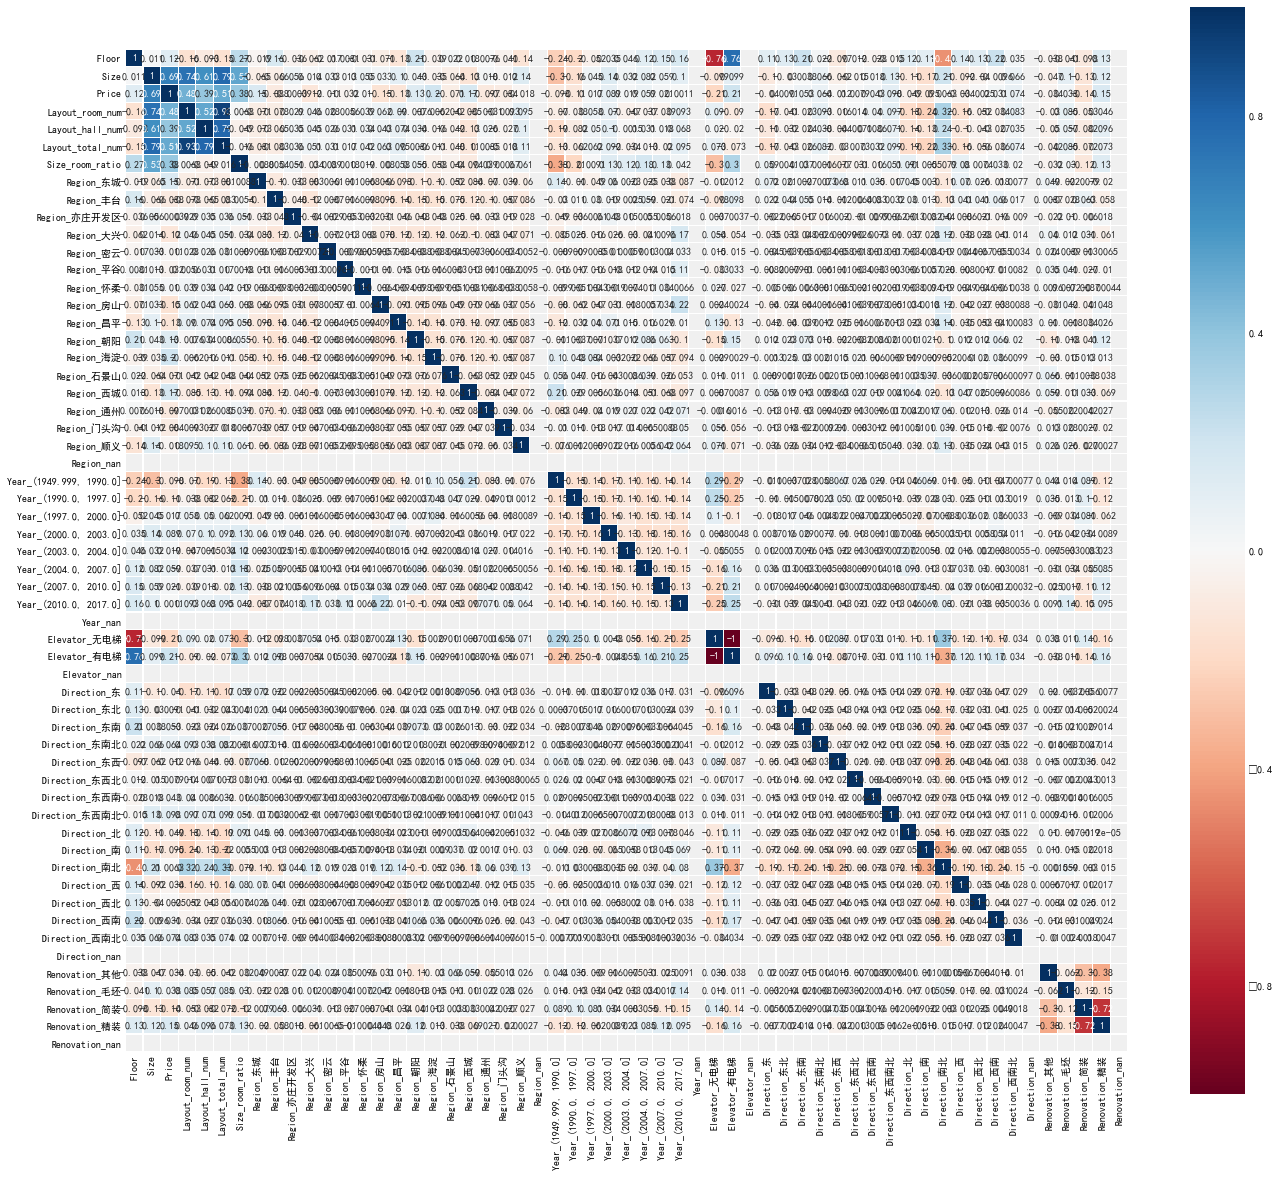

In [240]:
# data_corr 
colormap = plt.cm.RdBu
plt.figure(figsize=(20,20))
# plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [141]:
df['Direction'].value_counts()

南北      11368
南        2726
东西       1388
东南       1313
西南       1252
东         843
西         802
西北        734
东北        645
西南北       495
东南北       485
北         484
东西北       149
东西南       142
东西南北      120
Name: Direction, dtype: int64

In [156]:
# 分配数据集-训练集和测试集
prices = df['Price']
features = df.drop('Price', axis = 1)
print('北京二手房房价有数据 {0} 条，字段 {1} 个。'.format(*df.shape))
df.head()

北京二手房房价有数据 22946 条，字段 290 个。


,Floor,Size,Price,Layout_room_num,Layout_hall_num,Layout_total_num,Size_room_ratio,Region_东城,Region_丰台,Region_亦庄开发区,...,Direction_西,Direction_西北,Direction_西南,Direction_西南北,Direction_nan,Renovation_其他,Renovation_毛坯,Renovation_简装,Renovation_精装,Renovation_nan
0,6,75.0,780.0,3,1,4,18.75,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,6,60.0,705.0,2,1,3,20.00,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,16,210.0,1400.0,3,1,4,52.50,1,0,0,...,0,0,1,0,0,1,0,0,0,0
3,7,39.0,420.0,1,1,2,19.50,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,19,90.0,998.0,2,2,4,22.50,1,0,0,...,0,0,0,0,0,0,0,0,1,0


### - 数据划分
将数据集划分为训练集与测试集。

In [157]:
import numpy as np

# 转换训练测试集格式为数组
features = np.array(features)
prices = np.array(prices)

# 导入sklearn进行训练测试集划分
from sklearn.model_selection import train_test_split
features_train, features_test, prices_train, prices_test = train_test_split(features, prices, test_size=0.2, random_state=0)

### 建立模型
通过**交叉认证**缓解数据集过拟合的现象。建立决策树回归模型，通过**GridSearchCV**找到最优深度参数。

In [158]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# 利用GridSearchCV计算最优解
def fit_model(X, y):
    """ 基于输入数据 [X,y]，利于网格搜索找到最优的决策树模型"""
    
    cross_validator = KFold(10, shuffle=True)
    regressor = DecisionTreeRegressor()
    
    params = {'max_depth':[1,2,3,4,5,6,7,8,9,10]}
    scoring_fnc = make_scorer(performance_metric)
    grid = GridSearchCV(estimator = regressor, param_grid = params, scoring = scoring_fnc, cv = cross_validator)

    # 基于输入数据 [X,y]，进行网格搜索
    grid = grid.fit(X, y)
#     print pd.DataFrame(grid.cv_results_)
    return grid.best_estimator_

# 计算R2分数
def performance_metric(y_true, y_predict):
    """计算并返回预测值相比于预测值的分数"""
    from sklearn.metrics import r2_score
    score = r2_score(y_true, y_predict)

    return score

### 调参优化模型
可视化模型学习曲线，观察是否出现过拟合问题。

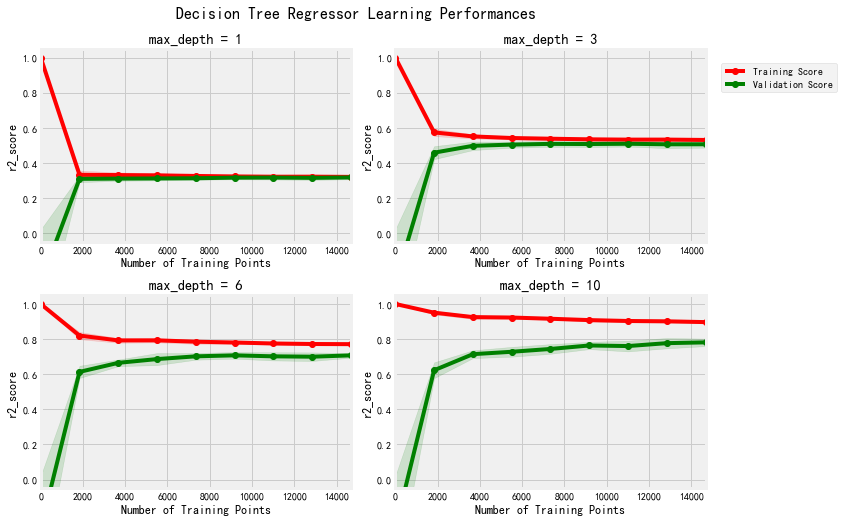

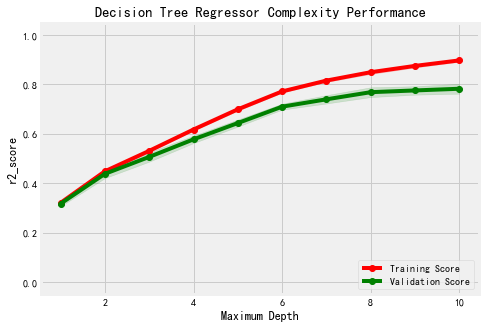

最理想模型的参数 'max_depth' 是 10 。
最优模型在测试数据上 R^2 分数 0.81。


In [159]:
import visuals as vs

# 分析模型
vs.ModelLearning(features_train, prices_train)
vs.ModelComplexity(features_train, prices_train)

optimal_reg1 = fit_model(features_train, prices_train)

# 输出最优模型的 'max_depth' 参数
print("最理想模型的参数 'max_depth' 是 {} 。".format(optimal_reg1.get_params()['max_depth']))

predicted_value = optimal_reg1.predict(features_test)
r2 = performance_metric(prices_test, predicted_value)

print("最优模型在测试数据上 R^2 分数 {:,.2f}。".format(r2))

### 结论

- 可以看到，决策树回归模型的决策深度**大约为 8 **的时候可以达到偏差与方差的平衡，也即最优模型。
- R2评分的准确率大约 **0.8**, 基本可以有效预测二手房房价。但是鉴于房价会受政策调控很大影响，因此预测结果仅供参考学习。

## 总结
本项目完成了从数据采集到数据分析，再到数据挖掘的整个数据处理过程，简单实现了北京二手房房价预测的需求。

各个阶段还有很多内容可以丰富

** - 数据采集部分：**
- 爬取更多影响房价的字段信息；
- 提高爬虫的爬取效率（尽管数据量不大）；
- 采集更多房屋中间商数据，补充数据集；

** - 数据分析部分：**
- 需要更深入研究特征信息对目标值的影响；
- 分析北京二手房房价的走势；
- 分析北京二手房房价的供需趋势；

** - 数据挖掘部分：**

为了使得预测更加准确，还有很多优化的地方，包括：
- 分析异常值，清除异常值或者填补异常值（随即森林拟合填补）；
- 爬虫或其他途径寻找更多对房价有影响的特征，例如附近是否有学区房，是否靠近地铁；
- 尝试其它更好模型，对比各个模型预测结果，选取最优模型；